<h1> Importing kaggle data to Google Big Query and running DNNLinearCombinedRegressor estimator using Tensorflow</h1>
<li></li>
<li>Data Source: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data </li>

In [2]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil
import tensorflow as tf
print(tf.__version__)
import datetime

1.8.0


### Big Query to get the data from the Big Query table we created using Kaggle train.csv file
<li>We extract data using Hash function FARM_FINGERPRINT applied to pickup date time to sample data</li>

In [4]:
import google.datalab.bigquery as bq
def sample_between(a, b):
    basequery = """
WITH daynames AS
  (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek)
SELECT
  fare_amount,
  daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count AS passengers,
  'notneeded' AS key    
FROM
  `nyc-taxi-fare-project.NY_Taxi_home.TrainingNYCTaxi`, daynames
WHERE
  fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """  
    sampler = "AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), EVERY_N) = 1"
    sampler2 = "AND {0} >= {1}\n AND {0} < {2}".format(
           "MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), EVERY_N * 100)",
           "(EVERY_N * {})".format(a), "(EVERY_N * {})".format(b)
        )
    return "{}\n{}\n{}".format(basequery, sampler, sampler2)

def create_query(phase, EVERY_N):
  """Phase: train (70%) valid (15%) or test (15%)"""
  query = ""
  if phase == 'train':
    # Training
    query = sample_between(0, 70)
  elif phase == 'valid':
    # Validation
    query = sample_between(70, 85)
  else:
    # Test
    query = sample_between(85, 100)
  return query.replace("EVERY_N", str(EVERY_N))

print create_query('train', 9)


WITH daynames AS
  (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek)
SELECT
  fare_amount,
  daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count AS passengers,
  'notneeded' AS key    
FROM
  `nyc-taxi-fare-project.NY_Taxi_home.TrainingNYCTaxi`, daynames
WHERE
  fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 9) = 1
AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 9 * 100) >= (9 * 0)
 AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS

### Creating three files, train,validate and test csv files

In [ ]:
def to_csv(df, filename):
  outdf = df.copy(deep = False) #copy by reference
  #outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # Reorder columns so that target is first column
  cols = outdf.columns.tolist() #column names converted into a list
  cols.remove('fare_amount') #just remove target column (fare amount) from column list
  cols.insert(0, 'fare_amount') #added back as first column
  print cols  # new order of columns
  outdf = outdf[cols] #df is reordered
  outdf.to_csv(filename, header = False, index_label = False, index = False) #since row number itself is index
  print "Wrote {} to {}".format(len(outdf), filename)

for phase in ['train', 'valid', 'test']:
  query = create_query(phase, 9)
  df = bq.Query(query).execute().result().to_dataframe()
  to_csv(df, 'taxi-{}.csv'.format(phase))

['fare_amount', u'dayofweek', u'hourofday', u'pickuplon', u'pickuplat', u'dropofflon', u'dropofflat', u'passengers', u'key']
Wrote 4206779 to taxi-train.csv


### Defining input columns, we are going to make new columns using feature engineering

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
LABEL_COLUMN = 'fare_amount'
KEY_FEATURE_COLUMN = 'key'
#Replacing null values with defaults
DEFAULTS = [[0.0], ['Sun'], [0], [-74.0], [40.0], [-74.0], [40.7], [1.0], ['nokey']]
TRAIN_STEPS = 1000

# These are the raw input columns, and will be provided for prediction also
INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

### Build the estimator

In [4]:
# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """
     Build an estimator starting from INPUT COLUMNS.
     These include feature transformations and synthetic features.
     The model is a wide-and-deep model.
  """

    # Input columns
    (dayofweek, hourofday, plat, plon, dlat, dlon, pcount, latdiff, londiff, euclidean) = INPUT_COLUMNS

    # Bucketize the lats & lons
    latbuckets = np.linspace(38.0, 42.0, nbuckets).tolist()
    lonbuckets = np.linspace(-76.0, -72.0, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(plat, latbuckets)
    b_dlat = tf.feature_column.bucketized_column(dlat, latbuckets)
    b_plon = tf.feature_column.bucketized_column(plon, lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(dlon, lonbuckets)

    # Feature cross
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets) #setting up grid
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
    day_hr =  tf.feature_column.crossed_column([dayofweek, hourofday], 24 * 7)

    # Wide columns and deep columns.
    wide_columns = [
        # Feature crosses 
        dloc, ploc, pd_pair,
        day_hr,

        # Sparse columns (#less options)
        dayofweek, hourofday,

        # Anything with a linear relationship
        pcount 
    ]

    deep_columns = [
        # Embedding_column to "group" together ...
        tf.feature_column.embedding_column(pd_pair, 10), #embedding_column in tf goes from pd_pair options to 10 options (controlled PCA)
        tf.feature_column.embedding_column(day_hr, 10),

        # Numeric columns
        plat, plon, dlat, dlon,
        latdiff, londiff, euclidean
    ]

    
    EVAL_INTERVAL = 30
    run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 10)
    #Defining the estimator
    estimator = tf.estimator.DNNLinearCombinedRegressor(
        model_dir = model_dir,
        linear_feature_columns = wide_columns,
        dnn_feature_columns = deep_columns,
        dnn_hidden_units = hidden_units,
        config = run_config)

    # add extra evaluation metric for hyperparameter tuning
    estimator = tf.contrib.estimator.add_metrics(estimator, add_eval_metrics)
    return estimator
  
  
### Evaluation metric function
def add_eval_metrics(labels, predictions):
  pred_values = predictions['predictions']
  return {
        'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)
          }

### Feature Engineering functions

In [5]:
# Create feature engineering function that will be used in the input and serving input functions
def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    lat1 = features['pickuplat']
    lat2 = features['dropofflat']
    lon1 = features['pickuplon']
    lon2 = features['dropofflon']
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    
    # set features for distance with sign that indicates direction
    features['latdiff'] = latdiff
    features['londiff'] = londiff
    dist = tf.sqrt(latdiff * latdiff + londiff * londiff)
    features['euclidean'] = dist
    return features

In [6]:
# Create serving input function to be able to serve predictions
def serving_input_fn():
    feature_placeholders = {
        # All the real-valued columns
        column.name: tf.placeholder(tf.float32, [None]) for column in INPUT_COLUMNS[2:]
    }
    feature_placeholders['dayofweek'] = tf.placeholder(tf.string, [None])
    feature_placeholders['hourofday'] = tf.placeholder(tf.int32, [None])

    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(add_engineered(features), feature_placeholders)

# Create input function to load data into datasets
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return add_engineered(features), label
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(file_list).map(decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        batch_features, batch_labels = dataset.make_one_shot_iterator().get_next()
        return batch_features, batch_labels
    return _input_fn




# Create estimator train and evaluate function
<li>This function trains and evvaluates simultaneously on the validation data</li>

In [7]:
    
    # Create estimator to train and evaluate
def train_and_evaluate(args):
  EVAL_INTERVAL = 30
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = args['eval_interval'],
                                      keep_checkpoint_max = 3)
  estimator = build_estimator(args['output_dir'], args['nbuckets'], args['hidden_units'])
  '''estimator = tf.estimator.DNNRegressor(
                       model_dir = output_dir,
                       feature_columns = INPUT_COLUMNS,
                       hidden_units = [64, 32],
                       config = run_config)
  '''
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('taxi-train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = args['train_steps'])
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn) # exporting the latest learnt model
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('taxi-valid.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 10, # start evaluating after N seconds
                       throttle_secs = args['eval_interval'],  # evaluate every N seconds
                       exporters = exporter)
 # eval_predict = estimator.predict(
 #                      input_fn = read_dataset('taxi-valid.csv', mode = tf.estimator.ModeKeys.PREDICT))
 # print(eval_predict.next())
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [8]:
### Defining the args dict
args = {'output_dir':'NYC_model',
       'nbuckets':16,
       'hidden_units':[64,64,64,8],
        'train_steps':500000, #418168
        'train_epochs':1,
       'train_data_paths':'taxi-train.csv',
        'eval_data_paths':'taxi-valid.csv',
       'train_batch_size':512,
       'eval_batch_size':512,
        'epochs_per_eval':1,
        'eval_interval':360
       }

In [9]:
from google.datalab.ml import TensorBoard 
TensorBoard().start('NYC_model')

TensorBoard was started successfully with pid 157. Click here to access it.

157

### Using only build estimator to make the model

In [ ]:
# Run the model
#shutil.rmtree('NYC_model', ignore_errors = True) # start fresh each time
model_nyc = train_and_evaluate(args)

In [13]:
#Loading the trained model for prediction
model = build_estimator(args['output_dir'], args['nbuckets'], args['hidden_units'])

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 30, '_session_config': None, '_keep_checkpoint_max': 10, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f74149db050>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'NYC_model', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 30, '_session_config': None, '_keep_checkpoint_max': 10, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f74135e1ad0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_serv

### Making new predictions on the test data 

In [14]:
predictions = model.predict(input_fn = read_dataset('taxi-test.csv', mode = tf.estimator.ModeKeys.PREDICT))
predict_dnn=[]
test_dnn = []
taxitest = pd.read_csv("taxi-test.csv")
faretest = taxitest.iloc[:,0]
for i in range(len(taxitest)):
  predict_dnn.append(predictions.next()['predictions'][0]) #list
  test_dnn.append(faretest[i])
  #print(predictions.next())
  
print('RMSE on test data : ',np.sqrt(np.mean(np.power((np.array(test_dnn)-np.array(predict_dnn)),2))))

df = pd.DataFrame({"fare_amount":predict_dnn})
#print(predict_dnn)
#print(test_dnn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from NYC_model/model.ckpt-400000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('RMSE on test data : ', 4.9347470890678204)


### RMSE on test data : 4.9347470890678204

### Comparing RMSE on validation data set from different models used

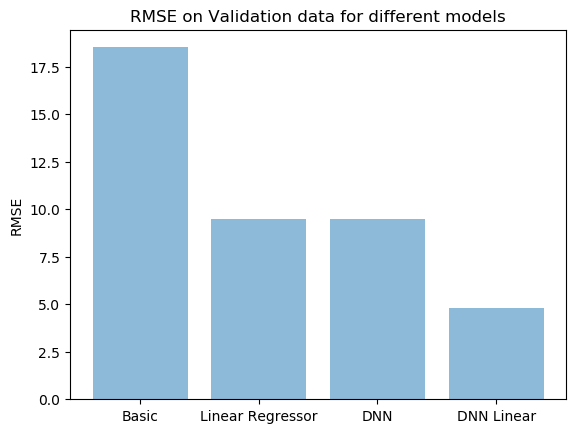

In [18]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Basic' , 'Linear Regressor', 'DNN', 'DNN Linear')
y_pos = np.arange(len(objects))
performance = [18.5216,9.4996,9.4908, 4.79]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.title('RMSE on Validation data for different models')
 
plt.show()